![dataworks-logo](images/dataworks-logo.png)
![ccdc-logo](images/logo.png)

# Introduction to Neural Networks for Deep Learning with TensorFlow

# TensorFlow example - Stroke prediction 

This notebook demonstrates some steps of a typical machine learning study that leads into the development of a neural network using TensorFlow.  Our sample dataset comes from [kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset).  Each row contains an instance of a patient and if they have had a stroke.  We will build a simple neural network classifer using TensorFlow to predict the `stroke` feature.  

## Brief data exploration 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df_orig = pd.read_csv('dataset_00/healthcare-dataset-stroke-data.csv')
df = df_orig

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


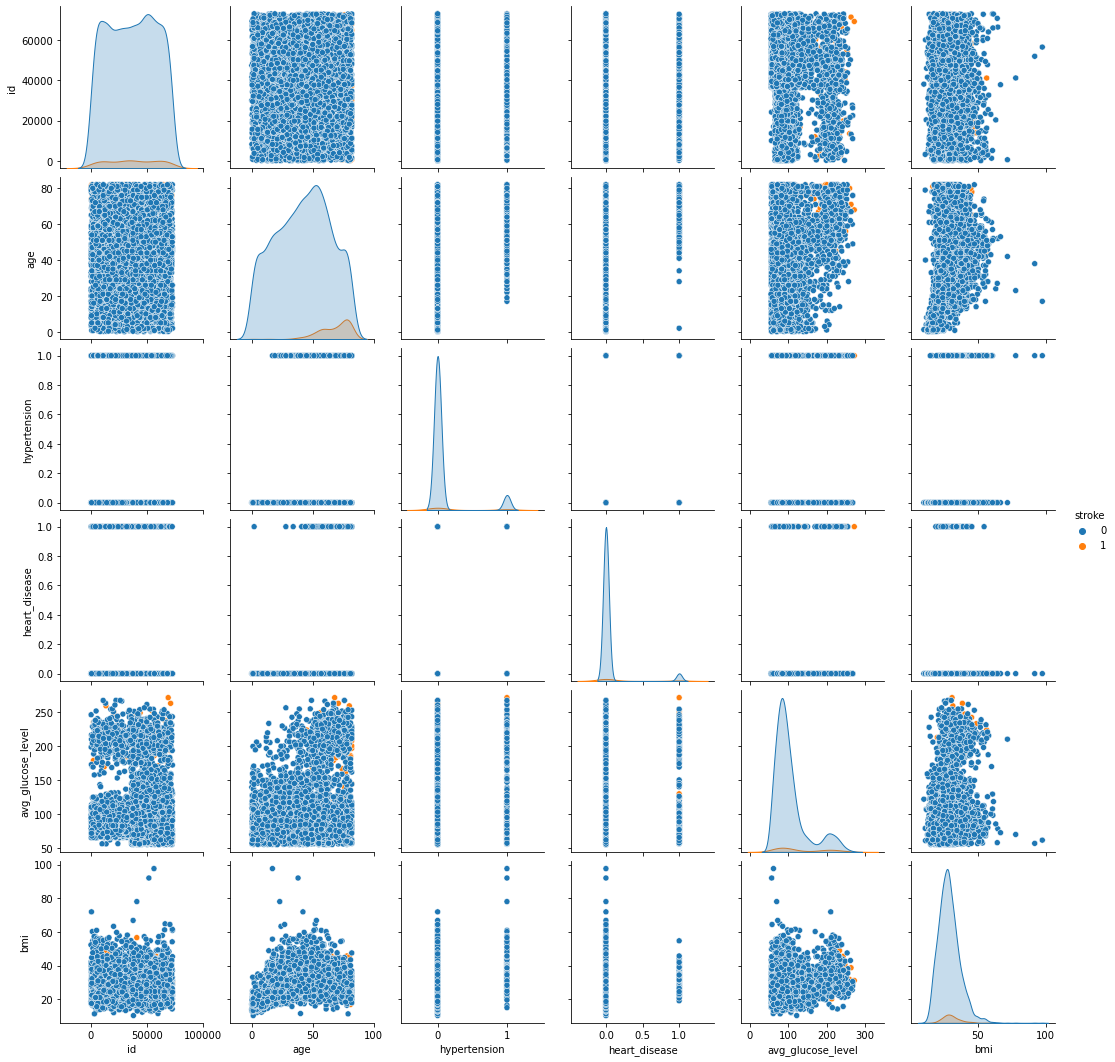

In [6]:
sns.pairplot(df, hue='stroke')

In [7]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

### Initial Observations 
+ Basic data cleaning required for handling outliers   
+ Data implance on the `stroke` feature.  May need to apply statistical over sampling for stroke=1.  

## Data preprocessing 

One-hot encode categorical features (gender, ever_married, work_type, Residence_type, smoking_status)

In [8]:
df = pd.get_dummies(df)
df.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [9]:
df.drop(['id', 'gender_Other', 'ever_married_Yes', 'work_type_children', 
                'Residence_type_Urban', 'smoking_status_smokes'], axis=1, inplace=True)

### Missing data 
Impute missing values for BMI with arthithmetic mean.  

In [10]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

### Outliers 
In a real study on stroke prediction, the points that could be considered outliers on the dimension of BMI or glucose level contain valuable information.  For the purpose of this example using TensorFlow, we will drop points that lie outside of the interquartile range.  In other cases, these points are important for building a good model!  

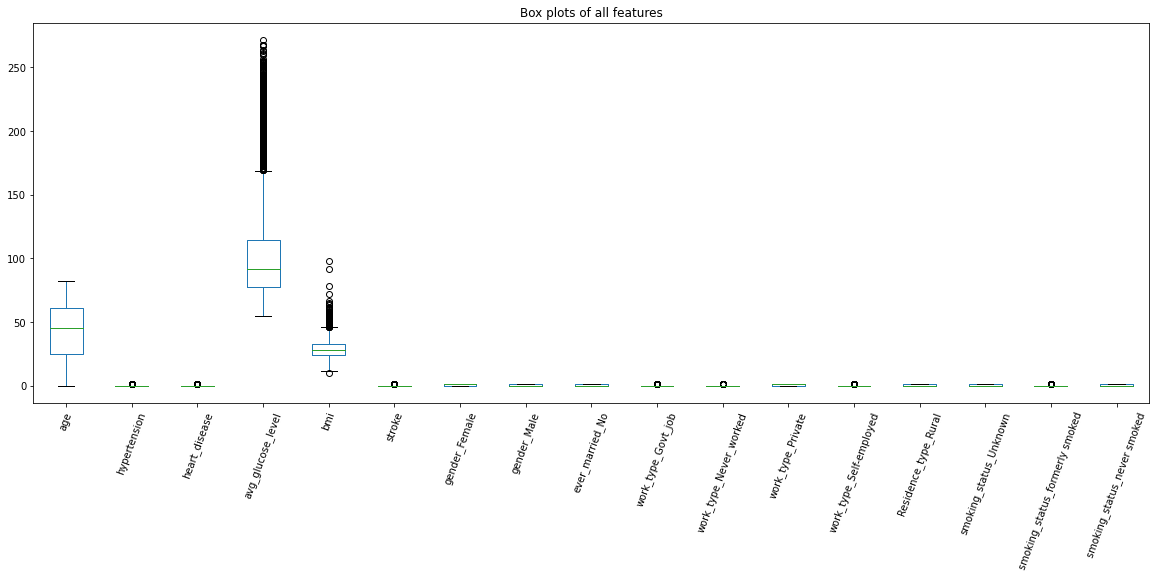

In [11]:
outlier= df.plot(kind='box',figsize=(20,7));
plt.xticks(rotation=70);
plt.title('Box plots of all features');

In [12]:
def remove_outlier(df_in, col_name):
    """ src: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


In [13]:
df_ = remove_outlier(df, 'age')
df_ = remove_outlier(df_, 'avg_glucose_level')
df_ = remove_outlier(df_, 'bmi')

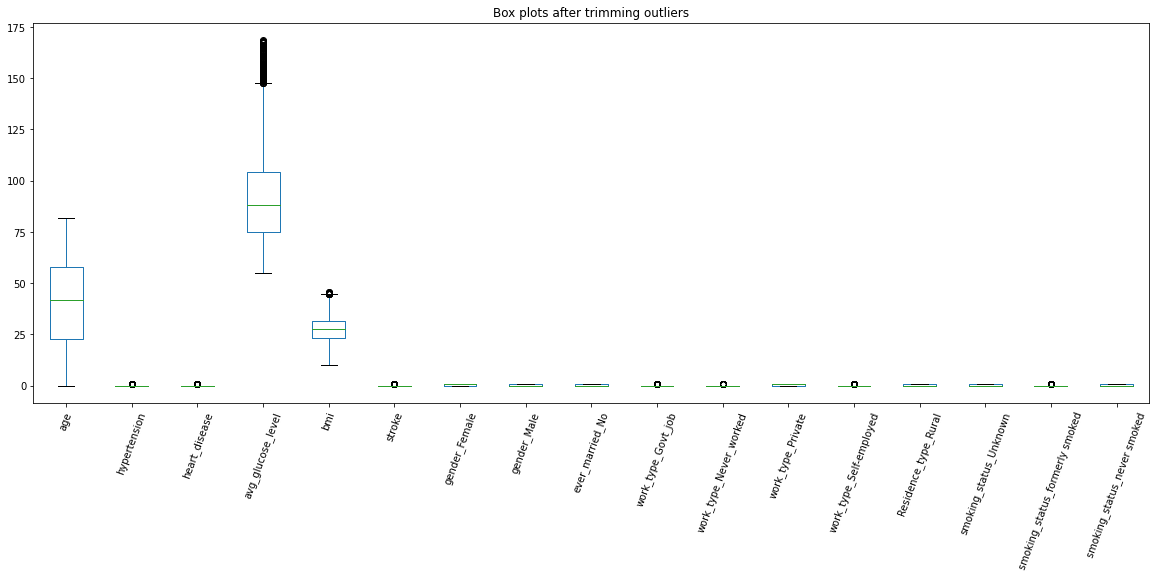

In [14]:
outlier= df_.plot(kind='box',figsize=(20,7));
plt.xticks(rotation=70);
plt.title('Box plots after trimming outliers')
df = df_ 

## Sampling & dataset preparation  
Next, we will address the data imbalance on the stroke feature with an oversampling technique called [SMOTE](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html).  Additionally, we will perform dataset splitting using the scikit-learn library.  

In [15]:
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
X = df.drop(['stroke'],axis = 1)
y = df['stroke']

X_train, X_test,y_train,y_test = train_test_split(X, y,test_size=0.30,random_state=1)

In [17]:
smpler = imblearn.over_sampling.SMOTE(random_state=2021)
X_train, y_train = smpler.fit_resample(X_train, y_train.ravel())


In [18]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Building 

In [19]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.regularizers import l2

In [20]:
model = tf.keras.Sequential([
    Dense(units=16, kernel_regularizer=l2(0.01), activation='relu'), 
    Dense(units=32, kernel_regularizer=l2(0.01), activation='relu'), 
    Dense(units=1, activation='sigmoid')
])


model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [21]:
hist = model.fit(X_train, y_train,
                 validation_split=0.2, 
                 epochs=100, 
                 verbose=1)

Epoch 1/100
148/148 [==============================] - 0s 2ms/step - loss: 0.7511 - accuracy: 0.7814 - val_loss: 0.6833 - val_accuracy: 0.8576
Epoch 2/100
148/148 [==============================] - 0s 640us/step - loss: 0.4545 - accuracy: 0.9153 - val_loss: 0.4307 - val_accuracy: 0.9102
Epoch 3/100
148/148 [==============================] - 0s 664us/step - loss: 0.3502 - accuracy: 0.9301 - val_loss: 0.3275 - val_accuracy: 0.9246
Epoch 4/100
148/148 [==============================] - 0s 650us/step - loss: 0.3044 - accuracy: 0.9320 - val_loss: 0.2955 - val_accuracy: 0.9153
Epoch 5/100
148/148 [==============================] - 0s 674us/step - loss: 0.2796 - accuracy: 0.9309 - val_loss: 0.3021 - val_accuracy: 0.8966
Epoch 6/100
148/148 [==============================] - 0s 633us/step - loss: 0.2626 - accuracy: 0.9331 - val_loss: 0.2374 - val_accuracy: 0.9381
Epoch 7/100
148/148 [==============================] - 0s 654us/step - loss: 0.2504 - accuracy: 0.9339 - val_loss: 0.2204 - val_accu

148/148 [==============================] - 0s 600us/step - loss: 0.1864 - accuracy: 0.9400 - val_loss: 0.1727 - val_accuracy: 0.9449
Epoch 58/100
148/148 [==============================] - 0s 627us/step - loss: 0.1857 - accuracy: 0.9419 - val_loss: 0.1378 - val_accuracy: 0.9551
Epoch 59/100
148/148 [==============================] - 0s 694us/step - loss: 0.1850 - accuracy: 0.9379 - val_loss: 0.2015 - val_accuracy: 0.9229
Epoch 60/100
148/148 [==============================] - 0s 755us/step - loss: 0.1850 - accuracy: 0.9396 - val_loss: 0.1797 - val_accuracy: 0.9322
Epoch 61/100
148/148 [==============================] - 0s 714us/step - loss: 0.1864 - accuracy: 0.9390 - val_loss: 0.1512 - val_accuracy: 0.9568
Epoch 62/100
148/148 [==============================] - 0s 627us/step - loss: 0.1835 - accuracy: 0.9436 - val_loss: 0.1684 - val_accuracy: 0.9373
Epoch 63/100
148/148 [==============================] - 0s 640us/step - loss: 0.1834 - accuracy: 0.9388 - val_loss: 0.2035 - val_accuracy

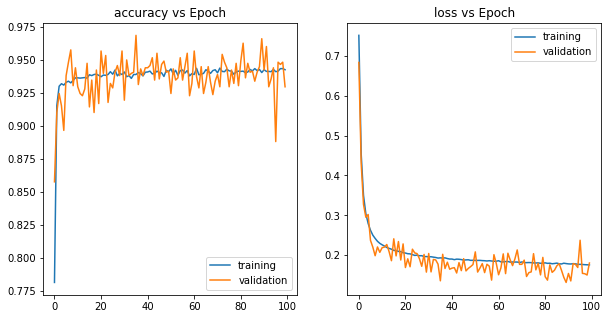

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
x_ = np.arange(len(hist.history['accuracy']))
y_ = ['accuracy', 'loss']

for idx, ax in enumerate(axes): 
    ax.plot(x_, hist.history[y_[idx]], hist.history['val_{}'.format(y_[idx])])
    ax.set_title('{} vs Epoch'.format(y_[idx]))
    ax.legend(['training', 'validation'])


## Checking model performance 

In [23]:
from sklearn.metrics import confusion_matrix, f1_score

In [24]:
y_pred = model.predict(X_test)
y_pred = [1 if n >= 0.5 else 0 for n in y_pred]

Model f1-score is 0.16091954022988506


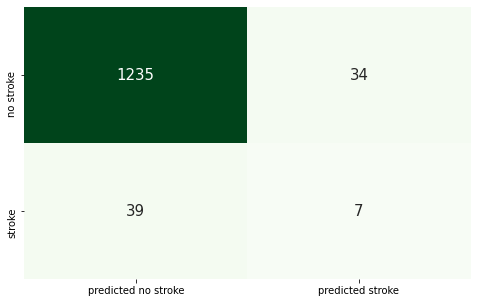

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap='Greens', annot = True, fmt = 'd', cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['no stroke', 'stroke'], xticklabels = ['predicted no stroke', 'predicted stroke']);

print("Model f1-score is {}".format(f1_score(y_test, y_pred)))